<a href="https://colab.research.google.com/github/jeremielassey/ML_Tweets_Prediction/blob/main/Prediction_Tweet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import re
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from gensim.models import Word2Vec
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,SpatialDropout1D,Embedding
from keras.callbacks import ModelCheckpoint

In [ ]:
train_dataset = pd.read_csv('/content/train.csv')
test_dataset = pd.read_csv('/content/test.csv')

In [ ]:
test_dataset.head()

,TweetId,TweetText
0,306486520121012224,'28. The home side threaten again through Maso...
1,286353402605228032,'@mrbrown @aulia Thx for asking. See http://t....
2,289531046037438464,'@Sochi2014 construction along the shores of t...
3,306451661403062273,'#SecKerry\u2019s remarks after meeting with F...
4,297941800658812928,'The #IPLauction has begun. Ricky Ponting is t...


In [ ]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6525 entries, 0 to 6524
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   TweetId    6525 non-null   int64 
 1   Label      6525 non-null   object
 2   TweetText  6525 non-null   object
dtypes: int64(1), object(2)
memory usage: 153.1+ KB


In [ ]:
train_dataset.isna().sum()

TweetId      0
Label        0
TweetText    0
dtype: int64

In [ ]:
train_text = train_dataset['TweetText']
label = train_dataset['Label']

test = test_dataset['TweetText']

train_text.head()

0    '#SecKerry: The value of the @StateDept and @U...
1                              '@rraina1481 I fear so'
2    'Watch video highlights of the #wwc13 final be...
3    'RT @chelscanlan: At Nitro Circus at #AlbertPa...
4    '@cricketfox Always a good thing. Thanks for t...
Name: TweetText, dtype: object

In [ ]:
def clean_text(text):
    # Remove Twitter handles starting with '@'
    text = re.sub(r'@\w+', '', text)
    # Remove non-alphanumeric characters and extra whitespace
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert multiple whitespace characters to a single space
    text = re.sub(r'\s+', ' ', text)
    # Convert the text to lowercase
    text = text.lower()
    return text

In [ ]:
train_text=train_text.apply(clean_text)
test_dataset['TweetText']=test_dataset['TweetText'].apply(clean_text)
train_text.head()

0    seckerry the value of the and is measured not ...
1                                            i fear so
2    watch video highlights of the wwc final betwee...
3    rt at nitro circus at albertpark theymakeitloo...
4         always a good thing thanks for the feedback 
Name: TweetText, dtype: object

In [ ]:
label.value_counts()

Sports      3325
Politics    3200
Name: Label, dtype: int64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_text,label, test_size=0.1, random_state=44, shuffle =True,stratify=label)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5872,)
(653,)
(5872,)
(653,)


In [ ]:
count_pip=Pipeline(
                [
                    ('count',CountVectorizer(ngram_range=(1,1))),
                    ('model',LogisticRegression(C=.8,solver='sag',max_iter=1000))
                ]
                )
count_pip.fit(X_train,y_train)

Pipeline(steps=[('count', CountVectorizer()),
                ('model',
                 LogisticRegression(C=0.8, max_iter=1000, solver='sag'))])

In [ ]:
print("CountVectorizer Model Train Score is :",count_pip.score(X_train,y_train))
print("Count Model Test Score is :",count_pip.score(X_test,y_test))

CountVectorizer Model Train Score is : 0.989441416893733
Count Model Test Score is : 0.9157733537519143


In [ ]:
idf_pip=Pipeline(
                [
                    ('tf_idf',TfidfVectorizer(ngram_range=(1,1))),
                    ('model',LogisticRegression(C=.8,solver='sag',max_iter=1000))
                ]
                )
idf_pip.fit(X_train,y_train)

Pipeline(steps=[('tf_idf', TfidfVectorizer()),
                ('model',
                 LogisticRegression(C=0.8, max_iter=1000, solver='sag'))])

In [ ]:
print("TfidfVectorizer Model Train Score is :",idf_pip.score(X_train,y_train))
print("TfidfVectorizer Model Test Score is :",idf_pip.score(X_test,y_test))

TfidfVectorizer Model Train Score is : 0.972241144414169
TfidfVectorizer Model Test Score is : 0.9203675344563553


In [ ]:
class Word2VecVectorizer:
    def __init__(self, word2vec_model):
        self.word2vec_model = word2vec_model
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        word2vec_vectors = []
        for tokens in X:
            vector = np.mean([self.word2vec_model.wv[word] for word in tokens if word in self.word2vec_model.wv], axis=0)
            word2vec_vectors.append(vector)
        return np.array(word2vec_vectors)
word2vec_model = Word2Vec(sentences=X_train, vector_size=100)
word2vec_pip = Pipeline([
    ('word2vec', Word2VecVectorizer(word2vec_model)),
    ('model', LogisticRegression(C=0.8, solver='sag', max_iter=1000))
])
word2vec_pip.fit(X_train, y_train)

Pipeline(steps=[('word2vec',
                 <__main__.Word2VecVectorizer object at 0x7d1abd0b5690>),
                ('model',
                 LogisticRegression(C=0.8, max_iter=1000, solver='sag'))])

In [ ]:
print("Word2VecVectorizer Model Train Score is :",word2vec_pip.score(X_train,y_train))
print("Word2VecVectorizer Model Test Score is :",word2vec_pip.score(X_test,y_test))

Word2VecVectorizer Model Train Score is : 0.6714918256130791
Word2VecVectorizer Model Test Score is : 0.678407350689127


array([[292,  28],
       [ 24, 309]])

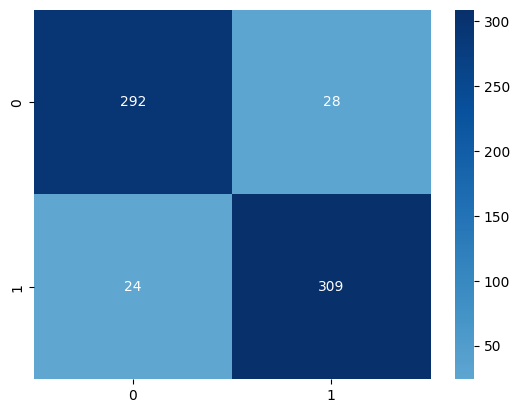

In [ ]:
y_pred=idf_pip.predict(X_test)
CM = confusion_matrix(y_test, y_pred)
sns.heatmap(CM,annot=True,center = True,fmt='g',cmap='Blues')
CM

In [ ]:
ClassificationReport = classification_report(y_test,y_pred)
print( ClassificationReport)

              precision    recall  f1-score   support

    Politics       0.92      0.91      0.92       320
      Sports       0.92      0.93      0.92       333

    accuracy                           0.92       653
   macro avg       0.92      0.92      0.92       653
weighted avg       0.92      0.92      0.92       653



In [ ]:
predictions=idf_pip.predict(test)

submission = pd.DataFrame({
    'Label': predictions},
     index=test_dataset['TweetId'])

submission.index.name = 'TweetId'

submission.to_csv('/content/submission_tweets_pred2.csv', index=False)

submission

,Label
TweetId,
306486520121012224,Sports
286353402605228032,Sports
289531046037438464,Politics
306451661403062273,Politics
297941800658812928,Sports
...,...
282023761044189184,Sports
303879735006601216,Politics
297956846046703616,Sports
